In [1]:
!pip install torch torchvision matplotlib numpy

     ------------------------------------- 199.4/199.4 MB 12.1 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 41.2 MB/s eta 0:00:00
     ---------------------------------------- 7.8/7.8 MB 41.6 MB/s eta 0:00:00
     --------------------------------------- 12.9/12.9 MB 40.9 MB/s eta 0:00:00
     ---------------------------------------- 6.2/6.2 MB 30.4 MB/s eta 0:00:00
  Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
  Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
     -------------------------------------- 179.3/179.3 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 32.6 MB/s eta 0:00:00
     ------------------------------------- 217.2/217.2 kB 12.9 MB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ---------------------------------------- 2.2/2.2 MB 34.9 MB/s eta 0:00:00
     ---------------------------------------- 56.0/56.0 kB 2.9 MB/s eta 0:00:00
     -------------------------------------


[notice] A new release of pip available: 22.3 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

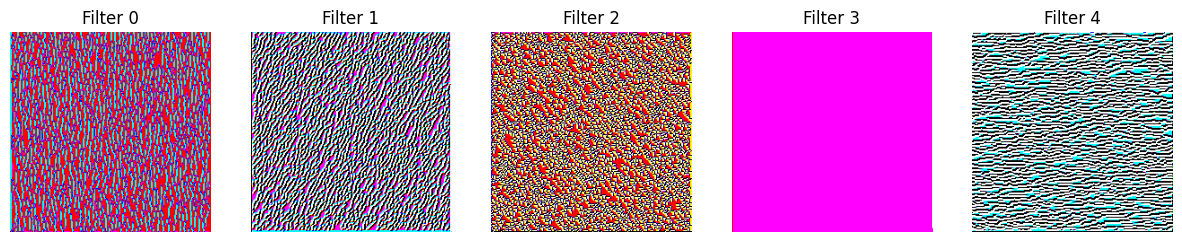

In [7]:



model = models.vgg16(pretrained=True)
model.eval()  

def visualize_feature(model, layer, filter_idx, img_size=(224, 224), lr=0.1, iterations=30):
    img = np.uint8(np.random.uniform(150, 180, img_size + (3,)))  
    img = transforms.ToTensor()(img).unsqueeze(0) 
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = normalize(img)
    
    img = img.detach().requires_grad_(True)
    
    optimizer = torch.optim.Adam([img], lr=lr)
    model.eval()

    activations = []
    def hook_function(module, input, output):activations.append(output[0, filter_idx])
    handle = layer.register_forward_hook(hook_function)
    for _ in range(iterations):
        optimizer.zero_grad()
        model(img)
        if len(activations) == 0:continue
        loss = -activations[-1].mean()  
        loss.backward()
        optimizer.step()

        img.data.clamp_(0, 1)
    handle.remove()
    img = img.detach().squeeze().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    return img
conv_layer = model.features[0]
num_filters = 5  
fig, ax = plt.subplots(1, num_filters, figsize=(15, 15))

for i in range(num_filters):
    feature_img = visualize_feature(model, conv_layer, filter_idx=i)
    ax[i].imshow(feature_img)
    ax[i].axis('off')
    ax[i].set_title(f'Filter {i}')

plt.show()


In [8]:
def trace_circuit(model, layer1_idx, layer2_idx):
    activations = {}
    def get_activation(layer_name):
        def hook(model, input, output):
            activations[layer_name] = output
            return hook
    layer1 = model.features[layer1_idx]
    layer2 = model.features[layer2_idx]
    hook1 = layer1.register_forward_hook(get_activation('layer1'))
    hook2 = layer2.register_forward_hook(get_activation('layer2'))
    sample_image = torch.zeros((1, 3, 224, 224))  
    model(sample_image)
    act1 = activations['layer1'].detach().numpy()
    act2 = activations['layer2'].detach().numpy()
    correlation = np.corrcoef(act1.reshape(act1.shape[1], -1), act2.reshape(act2.shape[1], -1))
    max_corr_indices = np.unravel_index(np.argmax(correlation[:act1.shape[1], act1.shape[1]:]), (act1.shape[1], act2.shape[1]))
    print(f"Most correlated filter pair between layer {layer1_idx} and layer {layer2_idx}: {max_corr_indices}")
    hook1.remove()
    hook2.remove()
trace_circuit(model, layer1_idx=0, layer2_idx=3)

Most correlated filter pair between layer 0 and layer 3: (np.int64(0), np.int64(0))


c:\Users\smart\OneDrive\Desktop\toy-models-of-superposition\interpretability\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\smart\OneDrive\Desktop\toy-models-of-superposition\interpretability\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
